In [26]:
# pip install ipyplot
!pwd

/home/ens/AQ66110/projects/genetec


In [18]:
# %matplotlib ipympl
import matplotlib
import torch
from tqdm import tqdm

from datasets import S_CAR
from nets import PPCNet
import os
import numpy as np
from torch.utils.data import Dataset
from torchvision.models import ResNet50_Weights, resnet50
from torch.nn import functional as Fn
import umap
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
import torchvision
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from PIL import Image
import pandas as pd
import seaborn as sn
import umap
from vis import apply_colormap_on_image
device = 'cuda:2'

In [2]:
# import sys
from importlib import reload
# del sys.modules["IndividualLandmarkNet"] 
# del IndividualLandmarkNet
import nets
reload(nets)
from nets import PPCNet


In [4]:
data_path='/home/ens/AQ66110/local/Datasets/stanfordCars'
dataset_train = S_CAR(data_path, mode='train', image_size=444, evaluate=True)
dataset_val = S_CAR(data_path, mode='test', image_size=444, evaluate=True)
num_cls = 196
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=32, shuffle=False, num_workers=8)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=32, shuffle=False, num_workers=8)
weights = ResNet50_Weights.DEFAULT
basenet = resnet50(weights=weights)
N_p = 7
net = PPCNet(basenet, N_p, num_classes=num_cls)
# resume = 'stanfordCars/scar_8_with_G7.pt'
resume = 'stanfordCars/scar_p7_mine_g_1_r.pt'
chk = torch.load(resume)
if 'C_centers' in chk:
    net.register_buffer('C_centers', chk['C_centers'])
    net.register_buffer('C_sec', chk['C_sec'])
    net.register_buffer('W_c', chk['W_c'])
    net.register_buffer('C_ind', chk['C_ind'])
    net.compute_Clabel()
net.load_state_dict(chk, False)
print(f'model loaded from {resume}')
device = 'cuda:2'
net = net.to(device)
net.epoch = 16
net = net.eval()
# dataset_train[0][0].shape

/tmp/ipykernel_1979232/3714011166.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(resume)


model loaded from stanfordCars/scar_p7_mine_g_1_r.pt


In [5]:
def getFeats(net, loader):
    net = net.eval()
    img_iter = tqdm(enumerate(loader),  total=len(loader), desc='Collecting features', ncols=0)
    maps, pooled, Y, Feat, = [],[],[],[]
    g_feat, g_patch, XG, concepts = [], [], [], []
    
    indices = []
    H, W = 0,0
    net.eval()
    with torch.no_grad():
        for i, (Xs, ys, index) in img_iter:
            indices.extend(index.numpy())
            batch_size, _, H, W = Xs.shape
            feats, m, scores, _scores, p_feats, G = net(Xs.to(device))
            g_feat.append(G["g_feat"].detach().cpu())
            g_patch.append(G["g_index"].detach().cpu())
            XG.append(G["XG"].detach().cpu())
            if 'concepts' in G  and G["concepts"] is not None:
                concepts.append(G["concepts"].detach().cpu())
            Y.append(ys.detach().cpu())
            maps.append(m.detach().cpu())
            pooled.append(p_feats.detach().cpu())
            Feat.append(feats.detach().cpu())
    N = len(indices)
#     p, d = 8, 256
#     part_pooled = pooled.reshape(-1, p, d)
    return torch.cat(pooled, dim=0), torch.cat(maps, dim=0), torch.cat(Y, dim=0), \
           torch.cat(Feat, dim=0).permute(0,2,1), np.asarray(indices), torch.cat(g_feat, dim=0), torch.cat(g_patch, dim=0), torch.cat(XG, dim=0), torch.cat(concepts, dim=0)

In [8]:
part_pooled, maps, Y, Feat, indices, g_feat, g_patch, XG, concepts = getFeats(net, train_loader)
p = part_pooled.shape[1]
w = net.proto_cls.weight
b, n =len(Y), 196
A_p = torch.stack([Fn.linear(part_pooled[:,i], w[:, i*256:i*256+256].cpu()) for i in range(p)], dim=1)
# p_scores = torch.stack([net.proto_cls[i](part_pooled[:, i].to(device)) for i in range(p)], dim=1).reshape(b, p, n, -1).cpu()
# A_p, A_p_i = p_scores.max(dim=-1)
O_c = Fn.linear(concepts, net.W_c.cpu())

N = len(Y)
pooled = part_pooled.reshape(Y.shape[0], -1)
w_g = net.global_cls.weight
O = A_p.sum(dim=1)
# O_p = Fn.linear(pooled[:, :-256].to(device), w[:, :-256])
O_g = net.global_cls(g_feat.to(device)) 
# O_p = Fn.linear(pooled[:, :-256].to(device), w[:, :-256])
print((O.argmax(dim=1).cpu() == Y).sum() / N)
print((O_g.argmax(dim=1).cpu() == Y).sum() / N)
print((O_c.argmax(dim=1).cpu() == Y).sum() / N)

O_max = O.argmax(dim=1)
true = (O_max.cpu() == Y)
# (pooled[0] @ w.T).argsort()
# O[0].argsort(descending=True)
# Y[true][0]
w[O_max].shape

tensor(0.9684)
tensor(0.8770)
tensor(0.9689)


torch.Size([8144, 1792])

In [9]:
part_pooled_t, maps_t, Y_t, Feat_t, indices_t, g_feat_t, g_patch_t, XG_t, concepts_t = getFeats(net, val_loader)
w = net.proto_cls.weight
p = maps_t.shape[1] - 1
A_p_t = torch.stack([Fn.linear(part_pooled_t[:,i], w[:, i*256:i*256+256].cpu()) for i in range(p)], dim=1)
A_p_t_max, A_p_t_arg = A_p_t.sum(dim=1).max(dim=1)
c_score = Fn.linear(concepts_t, net.W_c.cpu())
# II = (Y_t < 100).nonzero().squeeze()
O_g_t = net.global_cls.cpu()(g_feat_t)

# ii=II[19]

# val, top = A_p_t[ii,7].topk(3)
# maxO, argO = A_p_t[ii].sum(dim=0).topk(3)
# # print(val.detach(),top , Y_t[ii], maxO.detach(), argO, A_p_max[ii].detach(), A_p_arg[ii] )
print('feat:', (A_p_t_arg == Y_t).sum()/len(Y_t))
print('conc:', (c_score.argmax(dim=-1) == Y_t).sum()/len(Y_t))
print('Glob:', (O_g_t.argmax(dim=-1) == Y_t).sum()/len(Y_t))

# torchvision.transforms.functional.to_pil_image(dataset_val[ii][0])



feat: tensor(0.8586)
conc: tensor(0.8601)
Glob: tensor(0.7068)


In [10]:
print('fusion:', ((O_g_t*0.5 + c_score).argmax(dim=-1) == Y_t).sum()/len(Y_t))


fusion: tensor(0.8704)


tensor(180)
tensor([24.9350, 24.0478, 21.6663, 20.8295,  5.5952,  2.9262]) tensor([ 454, 2261,  905, 1795, 1323, 2721]) tensor([0, 4, 1, 3, 2, 6])
torch.Size([6, 3, 222, 222])


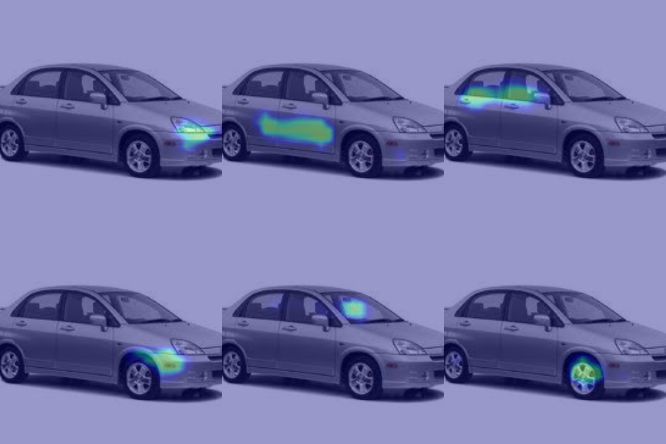

In [19]:
tmp = 0
print(Y_t[tmp])
showActivatedConcept(tmp, concepts_t,maps_t, net.W_c.cpu(), net.C_ind.cpu().long(), data_set=dataset_val)
# img = dataset_val[tmp][0]
# img = np.uint8(img.permute(1, 2, 0).numpy() * 255)
# print(concepts_t[tmp].topk(5))
# print((net.W_c.cpu()[c_score[tmp].argmax(dim=-1)] * concepts_t[tmp]).topk(5))
# Image.fromarray(img)

tensor(0)
tensor([17.4689, 17.3745, 16.7903, 14.1265, 13.9722, 13.8747, 13.0953, 12.6537,
        12.5299]) tensor([7203, 2183, 2914, 5210, 7303, 3807, 4711, 4209, 6857])
tensor([0.4122, 0.3957, 0.3730, 0.2995, 0.3460, 0.3290, 0.2781, 0.3306, 0.3350],
       grad_fn=<DivBackward0>)


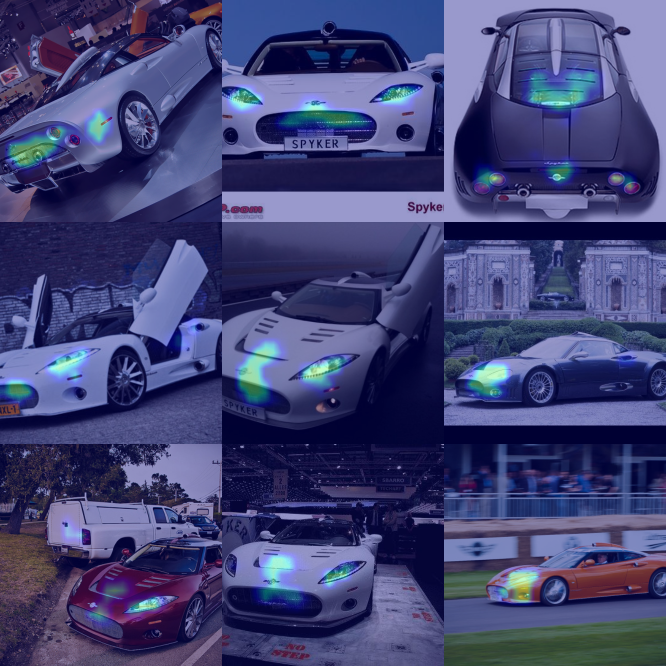

In [21]:
j=453
print(net.C_ind[j,0].cpu())
showConcept(j, concepts, net.W_c.cpu(), pp = net.C_ind[j,0].cpu().long())
# showConcept(j, concepts, torch.ones_like(net.W_c.cpu()), pp = net.C_ind[j,0].cpu().long())
# showConcept(j, concept, w_c, pp = LL[j])


In [1058]:
# del feats, m, scores, _scores, p_feats, G, net2, G2
import gc
with torch.no_grad():
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
gc.collect()    


0

torch.return_types.max(
values=tensor(95.8663, grad_fn=<MaxBackward0>),
indices=tensor(85)) tensor(85) tensor(90)
tensor([8.2972, 8.1058, 6.6287, 5.5367, 4.6047], grad_fn=<TopkBackward0>) tensor([415, 297,  46, 257, 478])


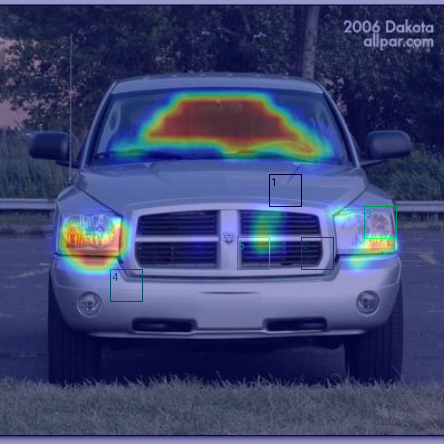

In [23]:
tmp = 28
      
img = dataset_val[tmp][0]
_, H,W = img.shape
mask = Fn.interpolate(maps_t[tmp,1:-1].sum(dim=0).unsqueeze(0).unsqueeze(0), size=(H, W), mode='bilinear').squeeze()
print(O_g_t[tmp].max(dim=-1),O_g_t[tmp].argmax(dim=-1), Y_t[tmp])
v, ind = (torch.relu(w_g[O_g_t[tmp].argmax()].cpu()) * g_feat_t[tmp]).topk(5)
# print(torch.relu(w_g[O_g[tmp].argmax()].cpu()) * g_feat[tmp])
# img = np.uint8(XX[ind[0]].permute(1,2,0).numpy() * 255)
patch = g_patch_t[tmp][ind][:, [1,0]] 
print(v, ind)
# print(patch)
patch = torch.cat([(patch / 14)*H - 16 , (patch / 14) * H + 16], dim=1)
jj = 18
img = torchvision.utils.draw_bounding_boxes (img, patch, '12345')
img = np.uint8(img.permute(1, 2, 0).numpy() * 255)
# print(patch)
heatmap_only, heatmap_on_image = apply_colormap_on_image(img, mask.cpu().numpy(), 'jet')
heatmap_on_image

tensor([117,  85,  90,  85,  94,  85,  85,  85,  85]) tensor([15.0481, 13.5980, 13.3193, 13.1337, 12.7257, 12.2804, 12.2362, 11.8240,
        11.4839], grad_fn=<SelectBackward0>)
tensor([[  7.,  87.,  23., 103.],
        [ 39.,  87.,  55., 103.],
        [ 55.,  87.,  71., 103.],
        [  7., 118.,  23., 134.],
        [ 55., 103.,  71., 119.],
        [  7., 103.,  23., 119.],
        [182., 118., 198., 134.],
        [166., 134., 182., 150.],
        [166., 103., 182., 119.]])


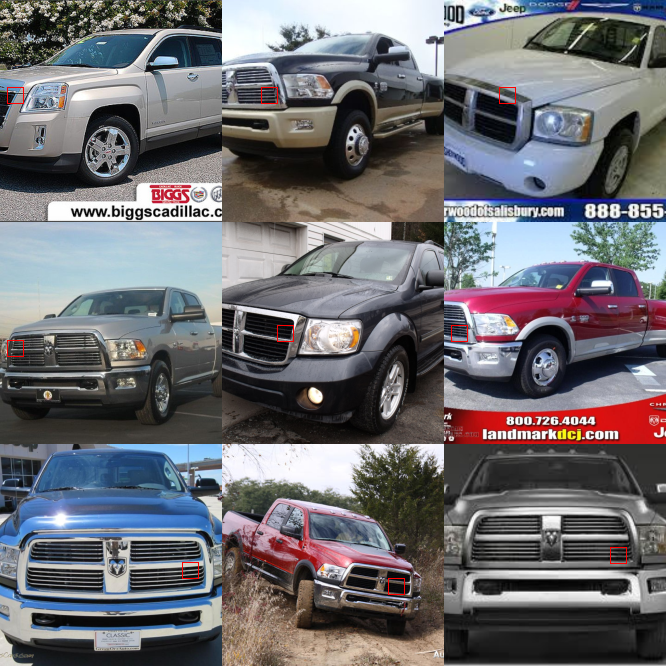

In [24]:
showPatch(415, g_feat, g_patch, torch.relu(w_g.cpu()))
# showPatch(300, g_feat, g_patch, torch.ones_like(w_g.cpu()))



In [16]:
import math
def closestDivisors(n):
    a = round(math.sqrt(n))
    while n%a > 0: a -= 1
    return a,n//a

def showConcept(j, concept, w_c, K=3, pp=0, w=True):
    data_set = dataset_train
    W,H = dataset_train[0][0].shape[1:]
    values, ind = torch.topk(w_c[Y]*concept, K*K, dim=0)
    # pp = LL[j,2]//196
    print(values[:,j], ind[:,j])
    I = (values[:,j] > 0)
    return imageTop(ind[:,j][I], pp, A_p, dataset_train)

def showActivatedConcept(i, concepts_t, maps, w_c, C_ind, data_set=dataset_val):
    K = 6
    K1,K2 = closestDivisors(K)
    img = data_set[i][0]
    _,W,H = img.shape
    c_score = Fn.linear(concepts_t[i], net.W_c.cpu())
    c_max, c_arg = c_score.max(dim=-1)
    val,ind =(w_c[c_arg] * concepts_t[i]).topk(K)
    pp = C_ind[ind,0]
    print(val / c_max * 100, ind, pp)
    X = Fn.interpolate(torch.stack([img for ii in ind], dim=0), size=(H//2, W//2), mode='bilinear')
    print(X.shape)
    img = np.uint8(rearrange(X, '(b1 b2) c h w ->  (b1 h) (b2 w) c', b1=K1, b2=K2).numpy() * 255)
    mask = Fn.interpolate(maps[i, pp,None], size=(H//2, W//2), mode='bilinear')
    mask = rearrange(mask, '(b1 b2) 1 h w ->  (b1 h) (b2 w)', b1=K1, b2=K2).cpu().numpy()
    heatmap_only, heatmap_on_image = apply_colormap_on_image(img, mask * 0.5, 'jet')
    return heatmap_on_image
    

def showPatch(j, g_feat, g_patch, w_g, K=3,data_set=dataset_train):
    K = 3
    # pooled = part_pooled.reshape(part_pooled.shape[0], -1)
    # values, ind = torch.topk(w[O_max] * Feat, K*K, dim=0)
    values, ind = torch.topk(w_g[Y] * g_feat, K*K, dim=0)
    _,W,H = data_set[0][0].shape
    X = Fn.interpolate(torch.stack([data_set[ii][0] for ii in ind[:,j]], dim=0), size=(H//2, W//2), mode='bilinear')
    patch = g_patch[ind[:, j]][:,j][:, [1,0]]
    patch = torch.cat([(patch / 14)*H//2 - 8 , (patch / 14) * H//2 + 8], dim=1)
    print(Y[ind[:,j]], values[:,j])
    print(patch)
    img = torch.stack([torchvision.utils.draw_bounding_boxes (X[jj], patch[jj:jj+1], colors=['red']) for jj in range(K*K)], dim=0)
    img = np.uint8(rearrange(img, '(b1 b2) c h w ->  (b1 h) (b2 w) c', b1=K).numpy() * 255)
    return Image.fromarray(img)
    
def imageTop(ind, pp, A_p, data_set=dataset_train):
    W,H = data_set[0][0].shape[1:]
    c_weight = torch.max(w.to(device), dim=0)[0]
    # values, ind = torch.topk(f[:,None] * p_scores[:,pp,:,:].max(dim=-1)[0], K*K, dim=0)
    K1,K2 = closestDivisors(len(ind))
    v,i = A_p[ind].sum(dim=1).max(dim=-1)
    print(A_p[ind,pp,i]/v)
    X = Fn.interpolate(torch.stack([data_set[ii][0] for ii in ind], dim=0), size=(H//2, W//2), mode='bilinear')
    img = np.uint8(rearrange(X, '(b1 b2) c h w ->  (b1 h) (b2 w) c', b1=K1, b2=K2).numpy() * 255)
    mask = Fn.interpolate(maps[ind.cpu()][:, pp: pp+ 1], size=(H//2, W//2), mode='bilinear')
    mask = rearrange(mask, '(b1 b2) 1 h w ->  (b1 h) (b2 w)', b1=K1, b2=K2).cpu().numpy()
    heatmap_only, heatmap_on_image = apply_colormap_on_image(img, mask * 0.5, 'jet')
    return heatmap_on_image

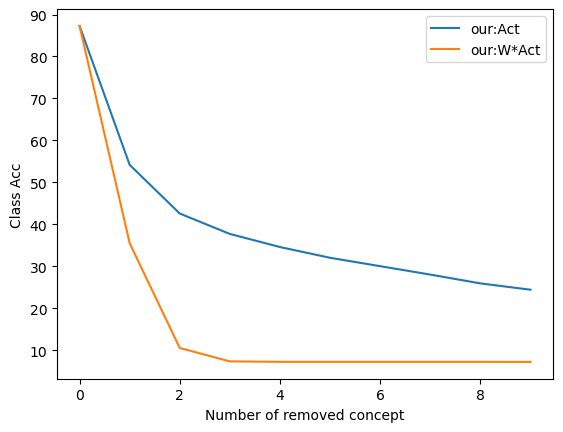

In [1447]:
def measure_Faithfulness_adaptive(A_p_t, Y_t, N):
    A_t_max, A_t_arg = A_p_t.sum(dim=1).max(dim=-1)
    p = A_p_t.shape[1]
    
    sortI1 = A_p_t.sum(dim=1).argsort(dim=-1, descending=True)
    acc = torch.zeros(N)
    acc[0] = (A_t_arg==Y_t).sum()/len(Y_t)
    A = A_p_t.clone()
    for i in range(1, N):
        j = i // A_p_t.shape[1]
        jj = i % A_p_t.shape[1]
        sortI = A_p_t[range(len(Y_t)),:,sortI1[:,j]].argsort(dim=-1, descending=True)
        
        A[torch.arange(len(Y_t)), sortI[:,jj], sortI1[:, j]] = 0
        v, arg = A.sum(dim=1).max(dim=-1)
        acc[i]=(arg==Y_t).sum()/len(Y_t)
    return acc

def measure_Faithfulness(Feat_t, Y_t, score, w, N=10):
    F_t_max, F_t_arg = score.max(dim=-1)
    O_t_max = A_p_t.sum(dim=1).argmax(dim=-1)
    acc = (O_t_max==Y_t).sum()/len(Y_t)
    s = 0
    sortI = score.argsort(dim=-1, descending=True)
    acc = torch.zeros(N)
    for i in range(N):
        A = Feat_t.clone()
        A[torch.arange(len(Y_t))[:,None], sortI[:, 0:i]] = 0
        O_t_new = Fn.linear(A, w.cpu())

        v, arg = O_t_new.max(dim=-1)
        acc[i] = (arg==Y_t).sum()/len(Y_t)
    return acc
    
fait={}
w_c = net.W_c.cpu()
c_score = Fn.linear(concepts_t, w_c)
c_arg = c_score.argmax(dim=-1)
fait["our:Act"] = measure_Faithfulness(concepts_t, Y_t, concepts_t, w_c, 10)*100

fait["our:W*Act"] = measure_Faithfulness(concepts_t, Y_t, w_c[c_arg] * concepts_t, w_c, 10)*100

for name in fait:
    plt.plot(fait[name], label=name)

plt.legend(loc="upper right")
plt.xlabel("Number of removed concept")
plt.ylabel("Class Acc")
plt.show()

In [1440]:
100 - (fait["our:W*Act"] / fait["our:Act"][0]) * 100

tensor([ 0.0000, 59.3331, 87.9595, 91.6215, 91.7355, 91.7355, 91.7355, 91.7355,
        91.7355, 91.7640])

In [1448]:
faitO = fait
%store faitO

Stored 'faitO' (dict)


In [1446]:
def measure_Sparseness(feats):
    sparseness = []
    uniform = torch.ones_like(feats) / feats.shape[-1]
    sparseness = 1 - Fn.cosine_similarity(feats.abs(), uniform, dim=-1)
#     for cen in centers:
# #         c = cen[0]
#         for c in cen:
#             uniform = torch.ones_like(c) / c.shape[-1]
#             sparseness.append(1 - Fn.cosine_similarity(c.abs(), uniform, dim=-1))
    # sparseness = torch.Tensor(sparseness)
    sp_mean = sparseness.mean()
    sp_std = sparseness.std() / np.sqrt(len(sparseness))
    return sp_mean, sp_std
measure_Sparseness(concepts_t)
    

(tensor(0.5745), tensor(0.0006))

In [1435]:
# def measure_Stability(A_p_t, Y_t):
#     mean , std = 0,0
#     for yy in Y_t.unique():
#         yi = (Y_t == yy).nonzero().squeeze()
#     #     print(c, len(yi))
#         F_Y = Fn.normalize(A_p_t[yi].reshape(len(yi),-1))
#         SS = torch.einsum('n d, b d -> n b', F_Y, F_Y)
#         mean += (SS.mean() * len(yi)/len(Y_t))
#         std += (SS.std() * len(yi)/len(Y_t))

        
#     result = torch.Tensor([mean, std])
#     return result
    
# measure_Stability(A_p_t, Y_t)

def measure_Consistency(data_set, model_name, Y_t, Feat_t, score):
    D = [[] for i in range(len(Feat_t))]
    TopV, TopI = score.topk(30, dim=-1)
    F_max, _ =  score.max(dim=-1)
    for i in tqdm(range(len(data_set)), total=len(data_set), desc='Collecting activate for concepts', ncols=0):
        topV, topI = TopV[i], TopI[i]
        top = topI[topV > 0.25*F_max[i]]
        topV = topV[topV > 0.25*F_max[i]] 
        D[i] = list(zip(top.tolist(), (topV / F_max[i]).tolist()))
    all = 0
    for yy in Y_t.unique():
        yi = (Y_t == yy).nonzero().squeeze()
    #     print(c, len(yi))
        act = []
        for i in yi:
            act.extend(D[i.item()])
        DD = {}
        for t,v in act:
            if t not in DD:
                DD[t] = v
            else:
                DD[t] += v
        items = sorted(DD.items(), key = lambda tup: tup[1], reverse=True)
        if len(items) > 0:
            all += (items[0][1]/sum(DD.values())) * len(yi) 
        else:
            all += len(yi)
    result = all / (len(Y_t))
    return result

def measure_Stability(feat, Y):
    mean, std = 0, 0
    for yy in np.unique(Y):
        yi = (Y == yy).nonzero()[0]
        #     print(c, len(yi))
        F_Y = Fn.normalize(feat[yi].reshape(len(yi), -1))
        SS = torch.einsum('n d, b d -> n b', F_Y, F_Y)
        mean += (SS.mean() * len(yi) / len(Y))
        std += (SS.std() * len(yi) / len(Y))

    result = torch.Tensor([mean, std])
    return result


def measure_Stability_EnterClass(Feat_t, Y_t):
    mean, std = 0, 0
    Y_u = Y_t.unique()
    L = len(Y_u)
    stability = torch.zeros((L, L))
    for i in range(0, L):
        yi = (Y_t == Y_u[i]).nonzero().squeeze()
        F_Y_i = Fn.normalize(Feat_t[yi].reshape(len(yi), -1))
        for j in range(i + 1):
            yj = (Y_t == Y_u[j]).nonzero().squeeze()
            F_Y_j = Fn.normalize(Feat_t[yj].reshape(len(yj), -1))
            SS = torch.einsum('n d, b d -> n b', F_Y_i, F_Y_j)
            stability[i][j] = stability[j][i] = SS.mean()

    # result = torch.Tensor([mean])
    
    return stability

# print ("Intra:", measure_Stability(Feat_t, Y_t) * 100)
# stb = measure_Stability_EnterClass(concepts_t, Y_t)
print("Inter:", torch.triu(stb, 1).std() * 100)
print("Intra:", torch.diag(stb).std() * 100)
# print ("Inter:",  * 100)


# yy=0
# yi = (Y_t == yy).nonzero().squeeze()
# #     print(c, len(yi))
# F_Y = Fn.normalize(A_p_s[yi].reshape(len(yi),-1))
# SS = torch.einsum('n d, b d -> n b', F_Y, F_Y)
# SS.std()
    


Inter: tensor(9.3722)
Intra: tensor(6.1246)


In [55]:
C_norm = [Fn.normalize(C, dim=-1) for C in centersA]
Feat_norm = Fn.normalize(Feat[:,:-1], dim=-1)
C_norm[0].shape
Feat_norm.shape

torch.Size([8144, 8, 3072])

In [366]:
def confusion_mat(concept, Y, categories):
    concept_norm = Fn.normalize(concept, dim=-1)
    YI = [(Y.unsqueeze(1) == torch.Tensor(j)).nonzero(as_tuple=False)[:,0] for j in categories]
    concept_means = torch.stack([concept_norm[yi].mean(dim=0) for yi in YI], dim=0)
    conf_mat = torch.einsum('b d, n d -> b n', concept_means , concept_means)
    return conf_mat
    

In [370]:
conf_mat = confusion_mat(concept, Y, makes.values())
conf_mat.shape

torch.Size([49, 49])

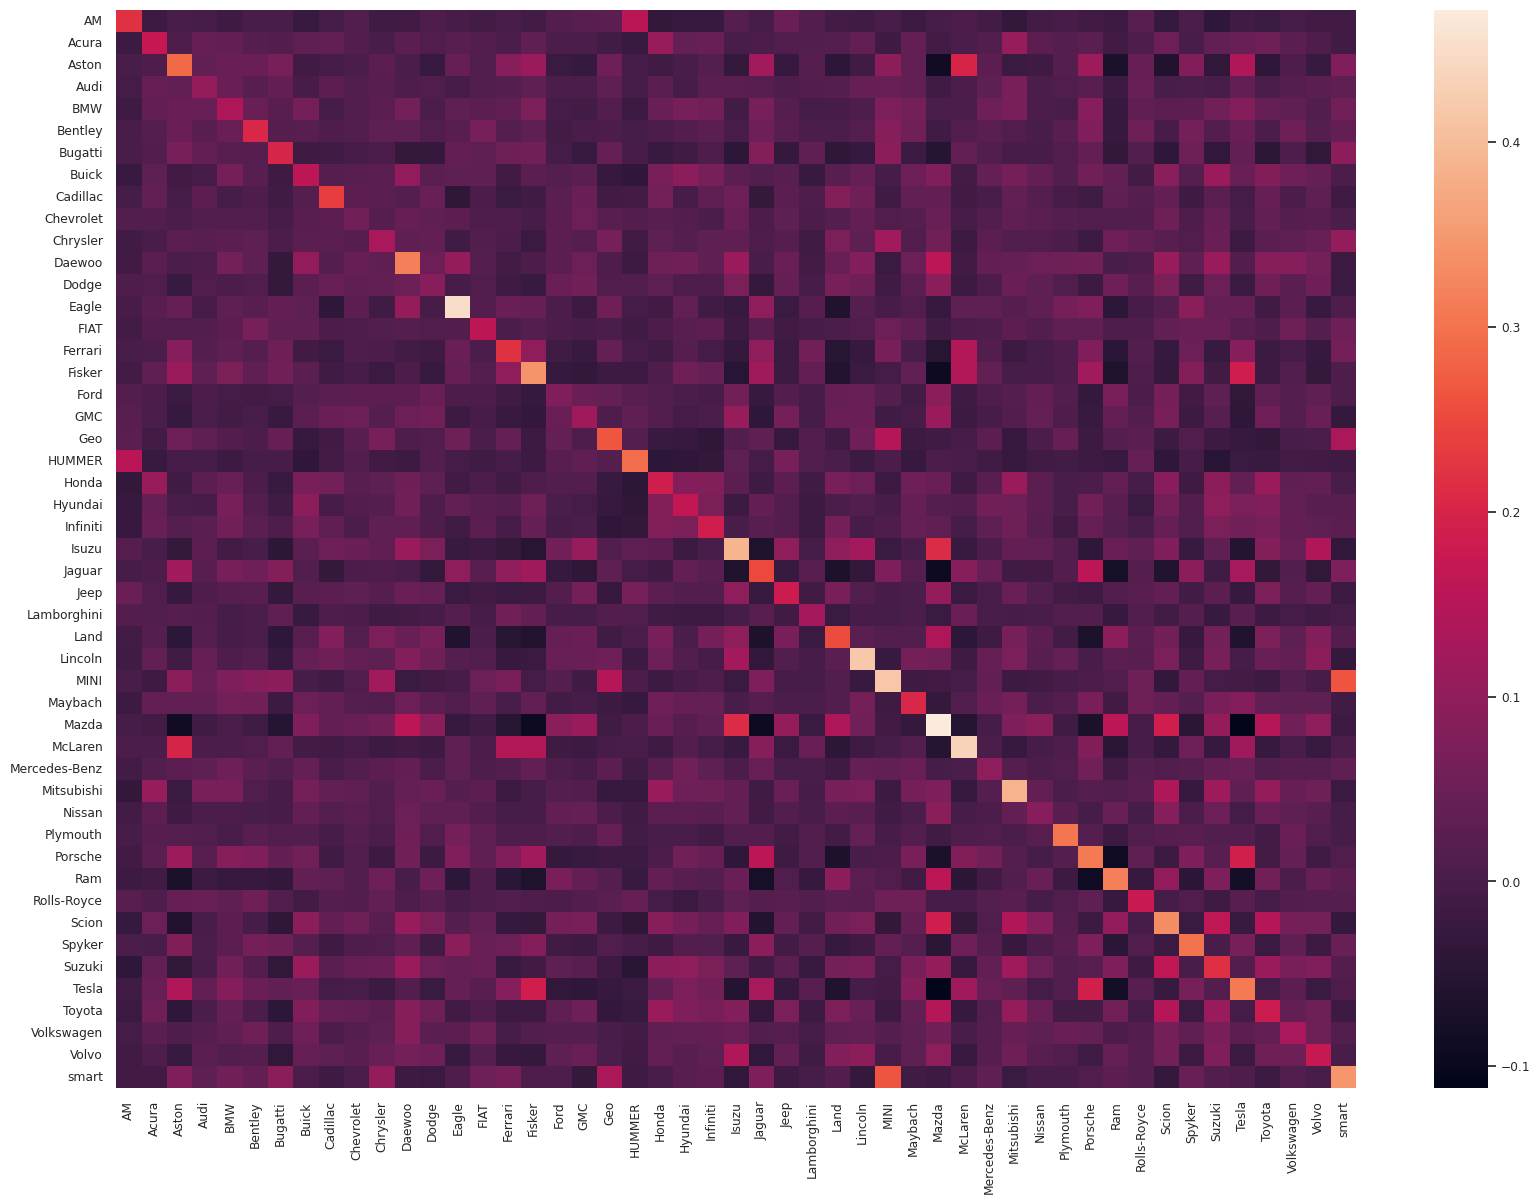

In [421]:
# conf_mat = confusion_mat(concept, Y, np.arange(196)[:,None])
# names = list(data_set._class_label.values())
# conf_mat = confusion_mat(A_p_t.reshape(len(Y_t), -1), Y_t, makes.values())
conf_mat = confusion_mat(concept.pow(3), Y, makes.values())
names = makes.keys()

corr = pd.DataFrame(conf_mat.detach())


corr.columns = names
corr.index = names


plt.figure(figsize = (20,14))
sn.set(font_scale=0.8) # for label size
sn.heatmap(corr) # font size
plt.savefig('make_conf_our.png', dpi=300)
# plt.show()


In [361]:
makesL = [(n.split('_')[0],i) for i,n in enumerate(names)]
makes = {}
for m,i in makesL:
    if m not in makes:
        makes[m]=[i]
    else:
        makes[m].append(i)
makes

{'AM': [0],
 'Acura': [1, 2, 3, 4, 5, 6],
 'Aston': [7, 8, 9, 10],
 'Audi': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 'BMW': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37],
 'Bentley': [38, 39, 40, 41, 42, 43],
 'Bugatti': [44, 45],
 'Buick': [46, 47, 48, 49],
 'Cadillac': [50, 51, 52],
 'Chevrolet': [53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74],
 'Chrysler': [75, 76, 77, 78, 79, 80],
 'Daewoo': [81],
 'Dodge': [82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
 'Eagle': [97],
 'FIAT': [98, 99],
 'Ferrari': [100, 101, 102, 103],
 'Fisker': [104],
 'Ford': [105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116],
 'GMC': [117, 118, 119, 120, 121],
 'Geo': [122],
 'HUMMER': [123, 124],
 'Honda': [125, 126, 127, 128],
 'Hyundai': [129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
 'Infiniti': [140, 141],
 'Isuzu': [142],
 'Jaguar': [143],
 'Jeep': [144, 145, 146

In [338]:
corr

,AM_General_Hummer_SUV_2000,Acura_RL_Sedan_2012,Acura_TL_Sedan_2012,Acura_TL_Type-S_2008,Acura_TSX_Sedan_2012,Acura_Integra_Type_R_2001,Acura_ZDX_Hatchback_2012,Aston_Martin_V8_Vantage_Convertible_2012,Aston_Martin_V8_Vantage_Coupe_2012,Aston_Martin_Virage_Convertible_2012,...,Toyota_Camry_Sedan_2012,Toyota_Corolla_Sedan_2012,Toyota_4Runner_SUV_2012,Volkswagen_Golf_Hatchback_2012,Volkswagen_Golf_Hatchback_1991,Volkswagen_Beetle_Hatchback_2012,Volvo_C30_Hatchback_2012,Volvo_240_Sedan_1993,Volvo_XC90_SUV_2007,smart_fortwo_Convertible_2012
AM_General_Hummer_SUV_2000,0.444482,-0.184534,-0.141309,-0.089631,-0.183414,0.010998,-0.170712,0.000685,-0.055515,-0.008779,...,-0.215985,-0.203039,0.056028,-0.179063,0.116602,-0.106400,-0.172528,0.110914,-0.065948,-0.045647
Acura_RL_Sedan_2012,-0.184534,0.510461,0.451681,0.264498,0.416395,-0.002315,0.413531,-0.038965,0.073697,0.014174,...,0.388713,0.287288,0.017272,0.259851,-0.100199,0.053332,0.127884,-0.058197,0.101889,-0.021502
Acura_TL_Sedan_2012,-0.141309,0.451681,0.601776,0.370215,0.460147,0.022236,0.393426,0.024049,0.121974,0.066669,...,0.362181,0.190657,-0.021968,0.155474,-0.061828,0.025049,0.030451,0.004834,0.007919,-0.075322
Acura_TL_Type-S_2008,-0.089631,0.264498,0.370215,0.521438,0.281430,0.113972,0.131559,0.016783,0.094256,0.011936,...,0.190890,0.100687,0.013855,0.138124,0.051593,0.057037,0.053234,0.093325,0.057970,-0.063932
Acura_TSX_Sedan_2012,-0.183414,0.416395,0.460147,0.281430,0.522621,0.003528,0.372160,-0.057997,0.039774,-0.024561,...,0.408757,0.320659,0.030584,0.211577,-0.096482,0.099785,0.129239,-0.083980,0.059734,-0.016686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Volkswagen_Beetle_Hatchback_2012,-0.106400,0.053332,0.025049,0.057037,0.099785,0.117985,0.081728,0.069933,0.129969,0.073106,...,0.100108,0.102372,-0.111297,0.207532,-0.049066,0.491938,0.188974,-0.130756,0.024674,0.158542
Volvo_C30_Hatchback_2012,-0.172528,0.127884,0.030451,0.053234,0.129239,0.108248,0.113721,-0.019948,0.039757,-0.028107,...,0.197518,0.279460,0.047479,0.243266,-0.040610,0.188974,0.436169,-0.078279,0.191150,0.121848
Volvo_240_Sedan_1993,0.110914,-0.058197,0.004834,0.093325,-0.083980,0.002390,-0.091202,-0.029950,-0.067988,-0.063186,...,-0.083759,-0.139173,0.152935,-0.096313,0.392258,-0.130756,-0.078279,0.570475,0.188703,-0.079274
Volvo_XC90_SUV_2007,-0.065948,0.101889,0.007919,0.057970,0.059734,0.010240,0.064831,-0.164615,-0.142237,-0.173759,...,0.075605,0.116479,0.237966,0.121199,0.211125,0.024674,0.191150,0.188703,0.529865,0.001482
